In [1]:
import datasets
import collections
import random

/home/liuyewei/miniconda3/envs/metalora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import (
    AutoTokenizer,
)

tokenizer = AutoTokenizer.from_pretrained("../models/Qwen3-8B/", padding_side="left", use_fast=True)
tokenizer.chat_template = "{%- if tools %}\n    {{- '<|im_start|>system\\n' }}\n    {%- if messages[0].role == 'system' %}\n        {{- messages[0].content + '\\n\\n' }}\n    {%- endif %}\n    {{- \"# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>\" }}\n    {%- for tool in tools %}\n        {{- \"\\n\" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- \"\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\\"name\\\": <function-name>, \\\"arguments\\\": <args-json-object>}\\n</tool_call><|im_end|>\\n\" }}\n{%- else %}\n    {%- if messages[0].role == 'system' %}\n        {{- '<|im_start|>system\\n' + messages[0].content + '<|im_end|>\\n' }}\n    {%- endif %}\n{%- endif %}\n{%- set ns = namespace(multi_step_tool=true, last_query_index=messages|length - 1) %}\n{%- for message in messages[::-1] %}\n    {%- set index = (messages|length - 1) - loop.index0 %}\n    {%- if ns.multi_step_tool and message.role == \"user\" and message.content is string and not(message.content.startswith('<tool_response>') and message.content.endswith('</tool_response>')) %}\n        {%- set ns.multi_step_tool = false %}\n        {%- set ns.last_query_index = index %}\n    {%- endif %}\n{%- endfor %}\n{%- for message in messages %}\n    {%- if message.content is string %}\n        {%- set content = message.content %}\n    {%- else %}\n        {%- set content = '' %}\n    {%- endif %}\n    {%- if (message.role == \"user\") or (message.role == \"system\" and not loop.first) %}\n        {{- '<|im_start|>' + message.role + '\\n' + content + '<|im_end|>\\n' }}\n    {%- elif message.role == \"assistant\" %}\n        {%- set reasoning_content = '' %}\n        {%- if message.reasoning_content is string %}\n            {%- set reasoning_content = message.reasoning_content %}\n        {%- else %}\n            {%- if '</think>' in content %}\n                {%- set reasoning_content = content.split('</think>')[0].rstrip('\\n').split('<think>')[-1].lstrip('\\n') %}\n                {%- set content = content.split('</think>')[-1].lstrip('\\n') %}\n            {%- endif %}\n        {%- endif %}\n        {%- if loop.index0 > ns.last_query_index %}\n            {%- if (loop.last or (not loop.last and reasoning_content)) and (enable_thinking is not defined or enable_thinking != false) %}\n                {{- '<|im_start|>' + message.role + '\\n<think>\\n' + reasoning_content.strip('\\n') + '\\n</think>\\n\\n' + content.lstrip('\\n') }}\n            {%- else %}\n                {{- '<|im_start|>' + message.role + '\\n' + content }}\n            {%- endif %}\n        {%- else %}\n            {{- '<|im_start|>' + message.role + '\\n' + content }}\n        {%- endif %}\n        {%- if message.tool_calls %}\n            {%- for tool_call in message.tool_calls %}\n                {%- if (loop.first and content) or (not loop.first) %}\n                    {{- '\\n' }}\n                {%- endif %}\n                {%- if tool_call.function %}\n                    {%- set tool_call = tool_call.function %}\n                {%- endif %}\n                {{- '<tool_call>\\n{\"name\": \"' }}\n                {{- tool_call.name }}\n                {{- '\", \"arguments\": ' }}\n                {%- if tool_call.arguments is string %}\n                    {{- tool_call.arguments }}\n                {%- else %}\n                    {{- tool_call.arguments | tojson }}\n                {%- endif %}\n                {{- '}\\n</tool_call>' }}\n            {%- endfor %}\n        {%- endif %}\n        {{- '<|im_end|>\\n' }}\n    {%- elif message.role == \"tool\" %}\n        {%- if loop.first or (messages[loop.index0 - 1].role != \"tool\") %}\n            {{- '<|im_start|>user' }}\n        {%- endif %}\n        {{- '\\n<tool_response>\\n' }}\n        {{- content }}\n        {{- '\\n</tool_response>' }}\n        {%- if loop.last or (messages[loop.index0 + 1].role != \"tool\") %}\n            {{- '<|im_end|>\\n' }}\n        {%- endif %}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|im_start|>assistant\\n' }}\n    {%- if enable_thinking is not defined or enable_thinking != false %}\n        {{- '<think>\\n\\n</think>\\n\\n' }}\n    {%- endif %}\n{%- endif %}"

In [3]:
def conversations_from_qapairs(item_list):
    for item in item_list:
        conversations = []
        for qa in item['qa_pairs']:
            question = qa['question']
            answer = qa['answer']
            conversations.append({"role": "user", "content": question})
            conversations.append({"role": "assistant", "content": answer})
        item['conversations'] = conversations
    return item_list

def save(data, save_path):
    import json, os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'w') as f:
        for item in data:
            id = item['id']
            context = item['context']
            conversations = item['conversations']
            f.write(json.dumps({"id": id, "context": context, "conversations": conversations}) + "\n")

In [4]:
q = "who is adam"
a = "I don't know"
tokensq = tokenizer.tokenize(q)
tokensa = tokenizer.tokenize(a)
message = [{"role": "user", "content": q}, {"role": "assistant", "content": a}]
tokensm = tokenizer.apply_chat_template(
    message,
    add_generation_prompt=False,   # adds the final assistant tag
    tokenize=True,               # returns text instead of IDs
    enable_thinking=False         # adds <think></think> block for the final assistant tag
)
chat_len = len(tokensm) - len(tokensq) - len(tokensa)
print(f"Chat overhead tokens: {chat_len}")

Chat overhead tokens: 10


In [5]:
from datasets import Dataset as HFDataset
import numpy as np

MAP_BATCH_SIZE = 2048
MAP_NUM_PROC = 16

def compute_context_and_conversations_tokens_num(data):
        if isinstance(data, list):
            hf_dataset = HFDataset.from_list(data)
        elif isinstance(data, HFDataset):
            hf_dataset = data
        else:
            raise TypeError("data must be a HuggingFace Dataset or a list of dicts")

        def compute_len(batch):
            context_enc = tokenizer(
                batch["context"],
                add_special_tokens=False,
                truncation=False,
                return_attention_mask=False,
                return_token_type_ids=False,
            )
            conversation_enc = tokenizer.apply_chat_template(
                batch["conversations"],
                add_generation_prompt=False,
                tokenize=True,
                enable_thinking=False,
            )
            return {"context_len": [len(ids) for ids in context_enc["input_ids"]], "conversations_len": [len(ids) for ids in conversation_enc]}

        hf_dataset = hf_dataset.map(
            compute_len,
            batched=True,
            batch_size=MAP_BATCH_SIZE,
            num_proc=MAP_NUM_PROC,
            desc="Computing token lengths",
            # writer_batch_size
        )

        return np.array(hf_dataset["context_len"], dtype=np.int32), np.array(hf_dataset["conversations_len"], dtype=np.int32)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_len_hist(
    lengths,
    bins=50,
    xlim=None,
    ylim=None,
    bin_range=None,
    density=False,
    logy=False,
    title="Length histogram",
    xlabel="Length",
    ylabel=None,
):
    lengths = np.asarray(lengths)
    lengths = lengths[np.isfinite(lengths)]

    # --- Compute statistics ---
    mean_val = np.mean(lengths)
    median_val = np.median(lengths)
    min_val = np.min(lengths)
    max_val = np.max(lengths)

    fig, ax = plt.subplots(figsize=(9, 5))

    hist_kwargs = dict(bins=bins, density=density)
    if bin_range is not None and isinstance(bins, (int, np.integer)):
        hist_kwargs["range"] = bin_range

    ax.hist(lengths, **hist_kwargs, alpha=0.7, edgecolor="black")

    # --- Plot statistical markers ---
    ax.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
    ax.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")
    ax.axvline(min_val, color="blue", linestyle=":", linewidth=2, label=f"Min = {min_val:.2f}")
    ax.axvline(max_val, color="purple", linestyle=":", linewidth=2, label=f"Max = {max_val:.2f}")

    # --- Annotation box ---
    stats_text = (
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Min: {min_val:.2f}\n"
        f"Max: {max_val:.2f}"
    )
    ax.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
    )

    # --- Labels and formatting ---
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel or ("Density" if density else "Count"))

    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    if logy:
        ax.set_yscale("log")

    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.tight_layout()
    plt.show()
    print(f"Total samples: {len(lengths)}")

In [7]:
def display_conversations(item_list, firstk=20):
    for i in range(firstk):
        print(item_list[i]['context'])
        for d in item_list[i]['conversations']:
            print(f"{d['role']}: {d['content']}")
        print("===================================================")

In [8]:
context_lens_dict = {}
conv_lens_dict = {}
item_list_dict = {}
pwc_datasets = []

# MSMACRO-MQA

In [9]:
import json
from datasets import concatenate_datasets


with open("../data/msmacro-mqa/train.jsonl", 'r') as f:
    data_train = [json.loads(line) for line in f]

with open("../data/msmacro-mqa/val.jsonl", 'r') as f:
    data_val = [json.loads(line) for line in f]

data = data_train + data_val

item_list = [{'context': data[i]['context'], 'qa_pairs': data[i]['conversations']} for i in range(len(data))]
# print(json.dumps(item_list[0], indent=4))

item_list = conversations_from_qapairs(item_list)
context_lens_dict['msmacro-mqa'], conv_lens_dict['msmacro-mqa'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['msmacro-mqa'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 92241/92241 [03:37<00:00, 424.85 examples/s]


In [10]:
display_conversations(item_list)
pwc_datasets.append("msmacro-mqa")

Herne Bay /hɜrn/ is a seaside town in Kent, South East England, with a population of 38,563. On the south coast of the Thames Estuary it is 7 miles (11 km) north of Canterbury and 5 miles (8 km) east of Whitstable. Herne Bay railway station is on the Chatham Main Line, which runs between Ramsgate in East Kent and London Victoria. Other stations on this line include Broadstairs, Margate, Whitstable, Faversham, Gillingham, Rochester and Bromley South. Herne Bay is around 1 hour and 40 minutes from London

Whitstable and Eastbourne have headed a list of the UK's fastest growing seaside resort destinations, with massive investment and an expansion of high-end tourism cited as major factors in a reversal of fortunes for the UK's seaside destinations. The trend, helped by £100 million worth of public investment in seaside towns, resulted in 21 per cent more UK holidaymakers staying overnight and spending almost a quarter more money at the English coast this year, it said.

Ranked by a growth

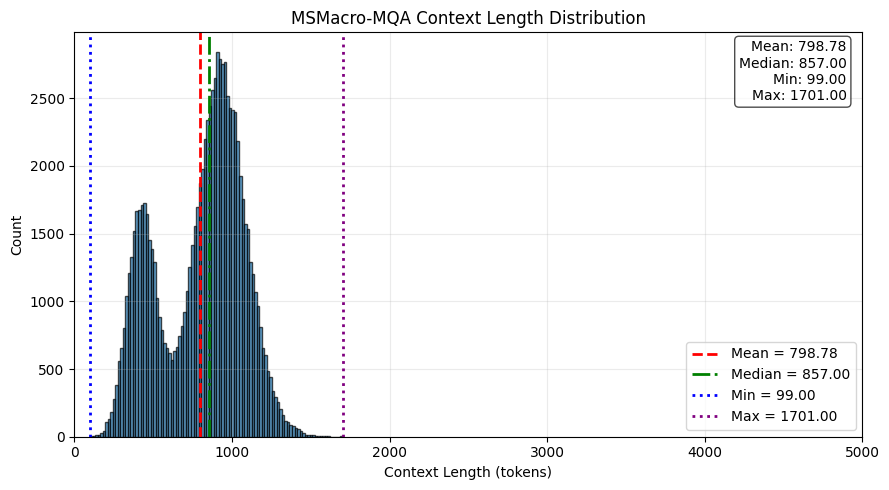

Total samples: 92241


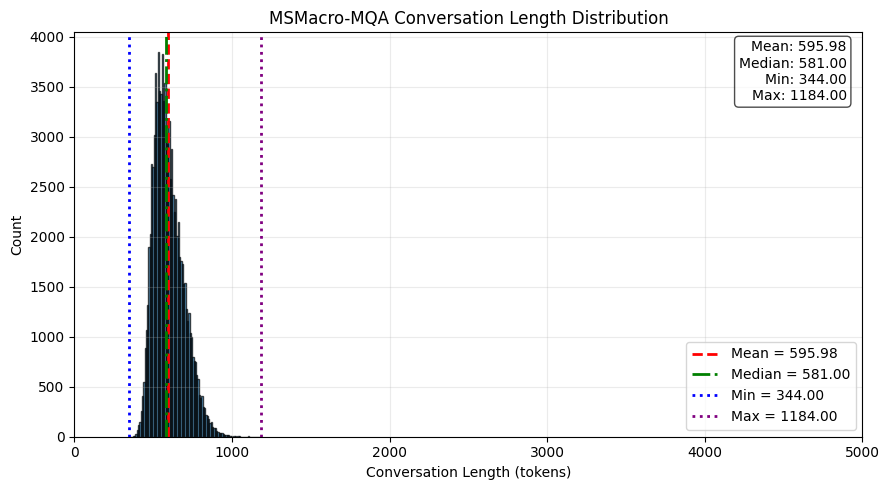

Total samples: 92241


In [11]:
plot_len_hist(
    context_lens_dict['msmacro-mqa'],
    bins=100,
    xlim=(0, 5000),
    title="MSMacro-MQA Context Length Distribution",
    xlabel="Context Length (tokens)",
)
plot_len_hist(
    conv_lens_dict['msmacro-mqa'],
    bins=100,
    xlim=(0, 5000),
    title="MSMacro-MQA Conversation Length Distribution",
    xlabel="Conversation Length (tokens)",
)

# MSMACROv2-MQA

In [13]:
import json
from datasets import concatenate_datasets


with open("../data/msmacrov2-mqa/train.jsonl", 'r') as f:
    data_train = [json.loads(line) for line in f]

data = data_train

item_list = [{'context': data[i]['context'], 'qa_pairs': data[i]['conversations']} for i in range(len(data))]
# print(json.dumps(item_list[0], indent=4))

item_list = conversations_from_qapairs(item_list)
context_lens_dict['msmacrov2-mqa'], conv_lens_dict['msmacrov2-mqa'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['msmacrov2-mqa'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 283761/283761 [12:21<00:00, 382.77 examples/s] 


In [14]:
display_conversations(item_list)
pwc_datasets.append("msmacrov2-mqa")

Rimfire Sporter is a new shooting sports activity that the CMP introduced in 2002 after four years of testing this concept in CMP Rimfire Sporter rifle clinics. Any gun enthusiast or hunter can shoot Rimfire Sporter because it uses smallbore sporter rifles that almost all of them already own.

Rimfire Sporter firing is done at 50 and 25 yards on a specially-designed target. 50-foot Rimfire Sporter targets are also now available for indoor shooting. Like the Garand and Springfield Matches, the Rimfire Sporter Rifle course of fire is challenging, but new shooters can successfully complete it.

Rimfire Sporter is an informal games match that introduces shooters to a course of fire akin to match competition yet conducted at a pace conducive to new shooters. The match is fired with off-the-rack, bolt-action or semi-automatic .22 caliber rifles (max 7.5 lbs. weight).

Any safe rimfire rifle with any type of action may be used. Rifles must be chambered for the .22 long rifle rimfire cartridge

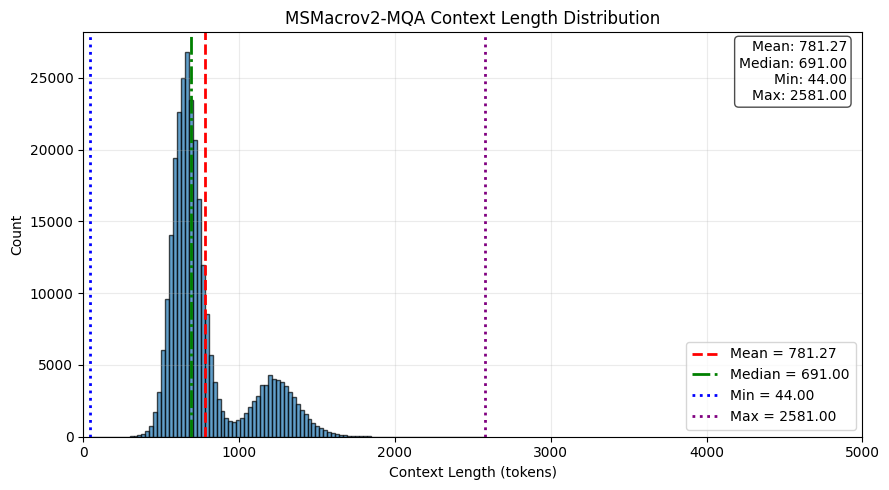

Total samples: 283761


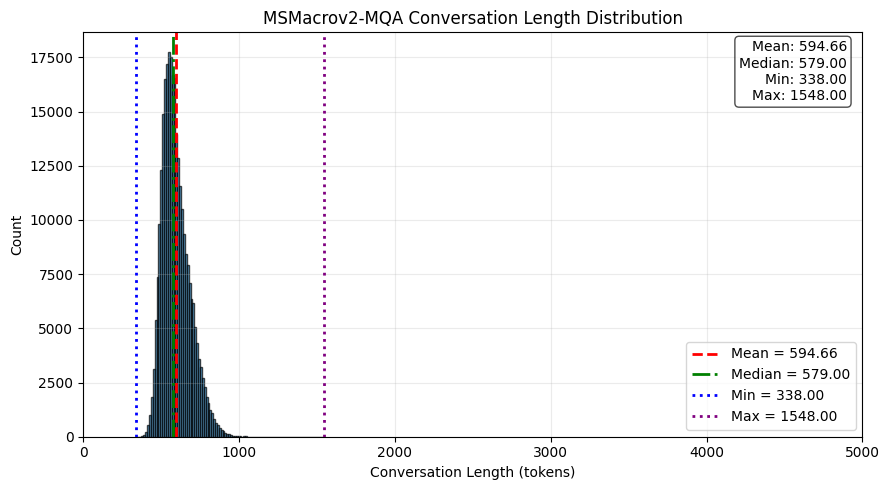

Total samples: 283761


In [15]:
plot_len_hist(
    context_lens_dict['msmacrov2-mqa'],
    bins=100,
    xlim=(0, 5000),
    title="MSMacrov2-MQA Context Length Distribution",
    xlabel="Context Length (tokens)",
)
plot_len_hist(
    conv_lens_dict['msmacrov2-mqa'],
    bins=100,
    xlim=(0, 5000),
    title="MSMacrov2-MQA Conversation Length Distribution",
    xlabel="Conversation Length (tokens)",
)

# QUAC

In [16]:
import json

with open("../data/quac/train_v0.2.json") as f:
    quac_data = json.load(f)['data']

# print(quac_data[0].keys())
# print(quac_data[0]['paragraphs'][0].keys())
# print(quac_data[0]['paragraphs'][0]['qas'][0].keys())

item_list = []
for item in quac_data:
    context = "\n\n".join([item['title'], item['background'], item['paragraphs'][0]['context']])
    qa_pairs = [{'question': item['paragraphs'][0]['qas'][i]["question"], 'answer': item["paragraphs"][0]['qas'][i]["orig_answer"]["text"]} for i in range(len(item['paragraphs'][0]['qas'])) \
        if item['paragraphs'][0]['qas'][i]["orig_answer"]['text'] != "CANNOTANSWER"]
    item_list.append({"context": context, "qa_pairs": qa_pairs})

item_list = conversations_from_qapairs(item_list)
context_lens_dict['quac'], conv_lens_dict['quac'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['quac'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 11567/11567 [00:41<00:00, 275.92 examples/s]


In [17]:
display_conversations(item_list)
pwc_datasets.append("quac")

Malayali

The Malayali people or Keralite people (also spelt Malayalee, Malayalam script: mlyaalli and keerlliiy[?]) are an Indian ethnic group originating from the present-day state of Kerala, located in South India. They are identified as native speakers of the Malayalam language, which is classified as part of the Dravidian family of languages. As they primarily live in Kerala, the word Keralite is used as an alternative to Malayali. According to the Indian census of 2011, there are approximately 33 million Malayalis in Kerala, making up 96.7% of the total population of the state.

According to the Indian census of 2001, there were 30,803,747 speakers of Malayalam in Kerala, making up 93.2% of the total number of Malayalam speakers in India, and 96.7% of the total population of the state. There were a further 701,673 (2.1% of the total number) in Karnataka, 557,705 (1.7%) in Tamil Nadu and 406,358 (1.2%) in Maharashtra. The number of Malayalam speakers in Lakshadweep is 51,100, whic

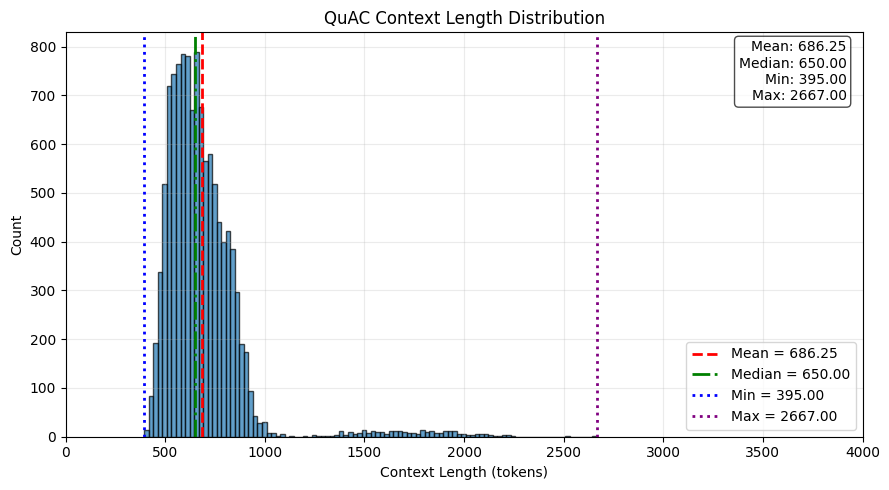

Total samples: 11567


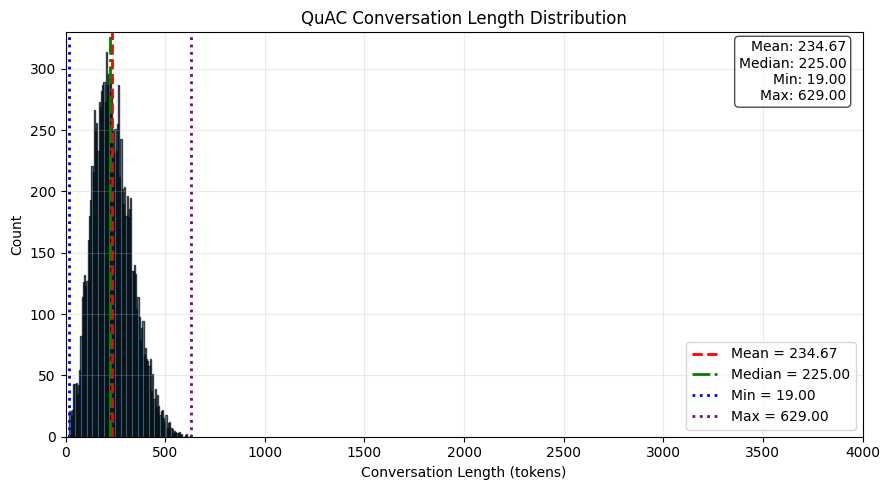

Total samples: 11567


In [18]:
plot_len_hist(
    context_lens_dict['quac'],
    bins=100,
    xlim=(0, 4000),
    title="QuAC Context Length Distribution",
    xlabel="Context Length (tokens)",
)
plot_len_hist(
    conv_lens_dict['quac'],
    bins=100,
    xlim=(0, 4000),
    title="QuAC Conversation Length Distribution",
    xlabel="Conversation Length (tokens)",
)

# COQA

In [19]:
from datasets import concatenate_datasets

# COQA ('stanfordnlp/coqa')
output_list = []
data = datasets.load_dataset('stanfordnlp/coqa')
data = concatenate_datasets([
    data["train"],
    data["validation"],
])
data = list(data)
# iterate all items in the dataset

random.seed(0)

item_list = []
for i, item in enumerate(data):
    context = item['story']
    questions = item['questions']
    answers = item['answers']["input_text"]
    item_list.append({
        'context': context,
        'qa_pairs': [{'question': q, 'answer': a} for q, a in zip(questions, answers)]
    })
item_list = conversations_from_qapairs(item_list)
context_lens_dict['coqa'], conv_lens_dict['coqa'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['coqa'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 7699/7699 [00:22<00:00, 335.76 examples/s] 


In [20]:
display_conversations(item_list_dict['coqa'])
pwc_datasets.append('coqa')

The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. 

The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. 

In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. 

The Vatican Secret Archives were separated from the library at the beginning of the 17th

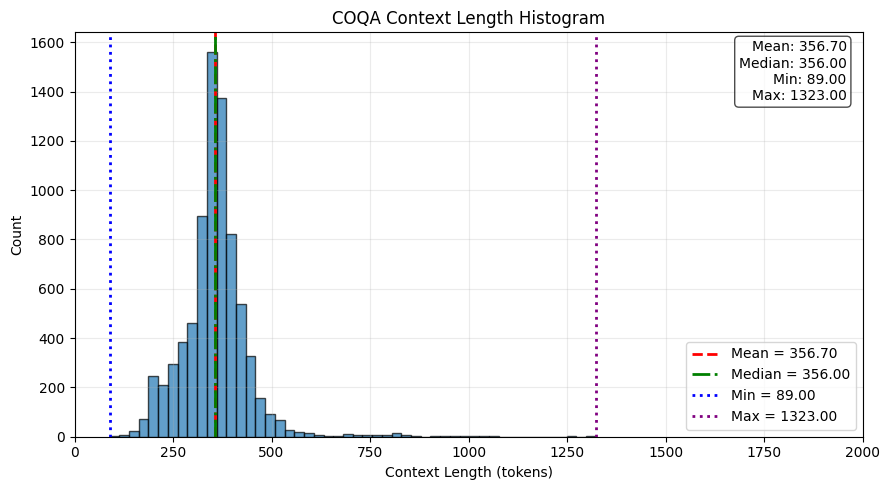

Total samples: 7699


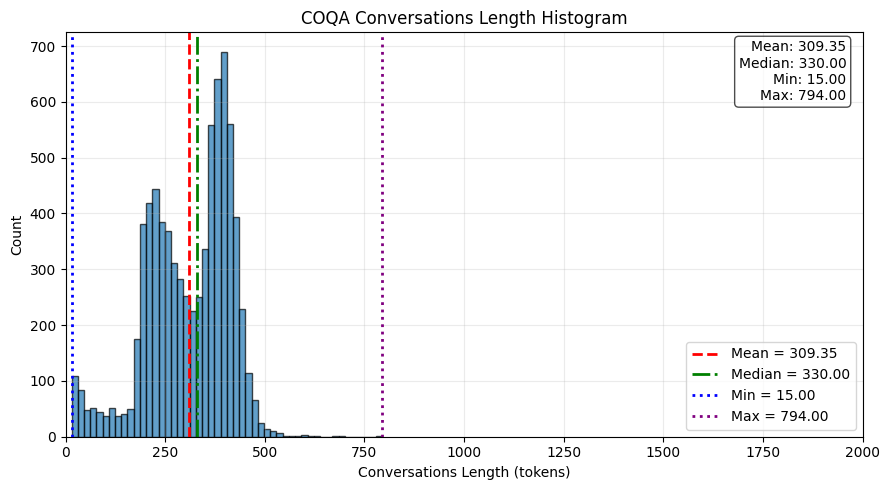

Total samples: 7699


In [21]:
plot_len_hist(
    context_lens_dict['coqa'],
    bins=50,
    xlim=(0, 2000),
    title="COQA Context Length Histogram",
    xlabel="Context Length (tokens)",
)
plot_len_hist(
    conv_lens_dict['coqa'],
    bins=50,
    xlim=(0, 2000),
    title="COQA Conversations Length Histogram",
    xlabel="Conversations Length (tokens)",
)

# DROP

In [22]:
# DROP ('ucinlp/drop')
output_list = []
data = datasets.load_dataset('ucinlp/drop')

data = concatenate_datasets([
    data["train"],
    data["validation"],
])
data = list(data)
random.seed(0)

context_to_item = {}
for item in data:
    context = item['passage']
    if context not in context_to_item:
        context_to_item[context] = []
    context_to_item[context].append(item)


item_list = []
for i, context in enumerate(context_to_item):
    qa_pairs = []
    for item in context_to_item[context]:
        question = item['question']
        answer = item['answers_spans']['spans'][0]
        qa_pairs.append({'question': question, 'answer': answer})
    item_list.append({
        'context': context,
        'qa_pairs': qa_pairs,
    })
item_list = conversations_from_qapairs(item_list)
context_lens_dict['drop'], conv_lens_dict['drop'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['drop'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 6108/6108 [00:19<00:00, 320.49 examples/s] 


In [23]:
display_conversations(item_list_dict['drop'])
pwc_datasets.append('drop')

To start the season, the Lions traveled south to Tampa, Florida to take on the Tampa Bay Buccaneers. The Lions scored first in the first quarter with a 23-yard field goal by Jason Hanson. The Buccaneers tied it up with a 38-yard field goal by Connor Barth, then took the lead when Aqib Talib intercepted a pass from Matthew Stafford and ran it in 28 yards. The Lions responded with a 28-yard field goal. In the second quarter, Detroit took the lead with a 36-yard touchdown catch by Calvin Johnson, and later added more points when Tony Scheffler caught an 11-yard TD pass. Tampa Bay responded with a 31-yard field goal just before halftime. The second half was relatively quiet, with each team only scoring one touchdown. First, Detroit's Calvin Johnson caught a 1-yard pass in the third quarter. The game's final points came when Mike Williams of Tampa Bay caught a 5-yard pass.  The Lions won their regular season opener for the first time since 2007
user: How many points did the buccaneers need 

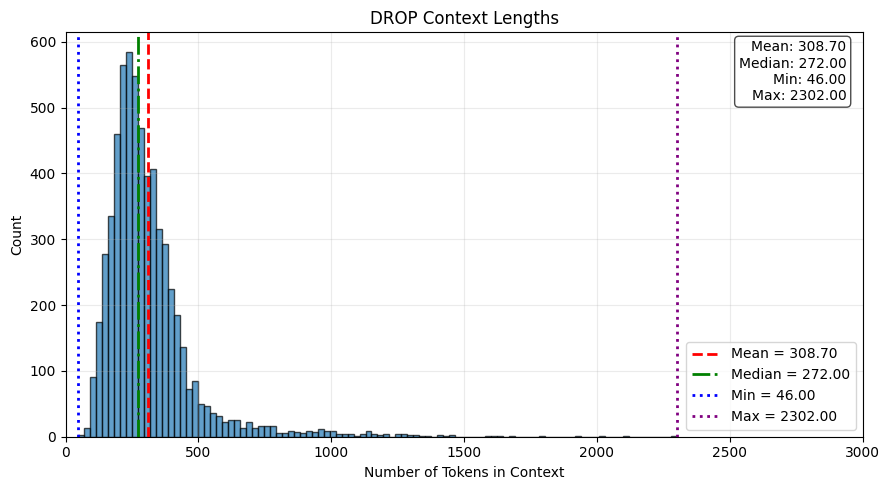

Total samples: 6108


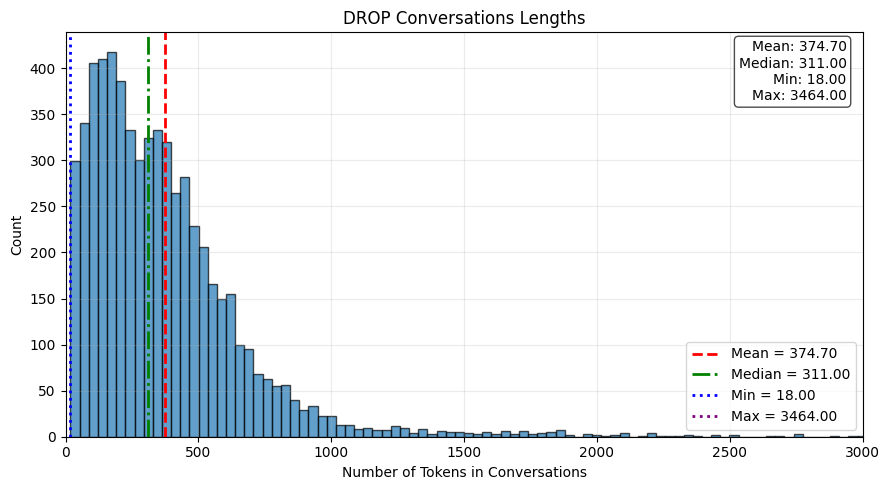

Total samples: 6108


In [24]:
plot_len_hist(
    context_lens_dict['drop'],
    bins=100,
    xlim=(0, 3000),
    title="DROP Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['drop'],
    bins=100,
    xlim=(0, 3000),
    title="DROP Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# narrativeqa

In [ ]:
# narrativeqa ('deepmind/narrativeqa')
output_list = []
data = datasets.load_dataset('deepmind/narrativeqa')
data = concatenate_datasets([
    data["train"],
    data["validation"],
    data["test"]
])
data = list(data)
context_to_item = {}
for item in data:
    context = item['document']['summary']['text']
    if context not in context_to_item:
        context_to_item[context] = []
    context_to_item[context].append(item)
for i, context in enumerate(context_to_item):
    if len(context.split()) > 2048:
        print(f"skip context len: {len(context.split())}")
        continue
    qa_pairs = []
    for item in context_to_item[context]:
        question = item['question']['text']
        answer = item['answers'][0]['text']
        qa_pairs.append({'question': question, 'answer': answer})
    while sum([len(qa["question"].split()) for qa in qa_pairs]) + sum([len(qa["answer"].split()) for qa in qa_pairs]) > 512:
        qa_pairs = qa_pairs[:-1]
        # print(f"q eln: {[len(qa['question'].split()) for qa in qa_pairs]}, a len: {[len(qa['answer'].split()) for qa in qa_pairs]}")
        # continue
    output_list.append({
        "id": f"narrativeqa.{i:04d}",
        'context': context,
        'qa_pairs': qa_pairs
    })
item_list = conversations_from_qapairs(output_list)
context_lens_dict['narrativeqa'], conv_lens_dict['narrativeqa'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['narrativeqa'] = item_list

# print(f"narrativeqa: {len(output_list)}, context len: {sum([len(x['context'].split()) for x in output_list]) / len(output_list)}")
# print(collections.Counter([len(item["qa_pairs"]) for item in output_list]))
# save(output_list, 'v4/narrativeqa.jsonl')

Computing token lengths (num_proc=16): 100%|██████████| 1572/1572 [00:30<00:00, 51.21 examples/s] 


In [26]:
display_conversations(item_list_dict['narrativeqa'])
pwc_datasets.append('narrativeqa')

 At Madeline Hall, an old mansion-house near Southampton belonging to the wealthy de Versely family, lives an elderly spinster Miss Delmar, the aunt of the earl de Versely and Captain Delmar. Miss Delmar invites Arabella Mason, the daughter of a deceased, well-liked steward to stay with her as a lower-class guest in the house. Captain Delmar is known to visit his aunt at Madeline Hall frequently, accompanied by his valet Ben Keene, who is also a private marine. Captain Delmar eventually suggests that Ben should propose to Arabella, and the two marry in secret, to the frustration of Miss Delmar and Arabella's mother. The captain is able to smooth over the situation with his aunt, even after it is discovered that Arabella was six months pregnant at the time of the marriage. She later gives birth to a boy, who takes the Captain's Christian name and Ben's surname--the titular Percival Keene.
The family moves to Chatham, after Ben is ordered back with his detachment. Arabella opens up a suc

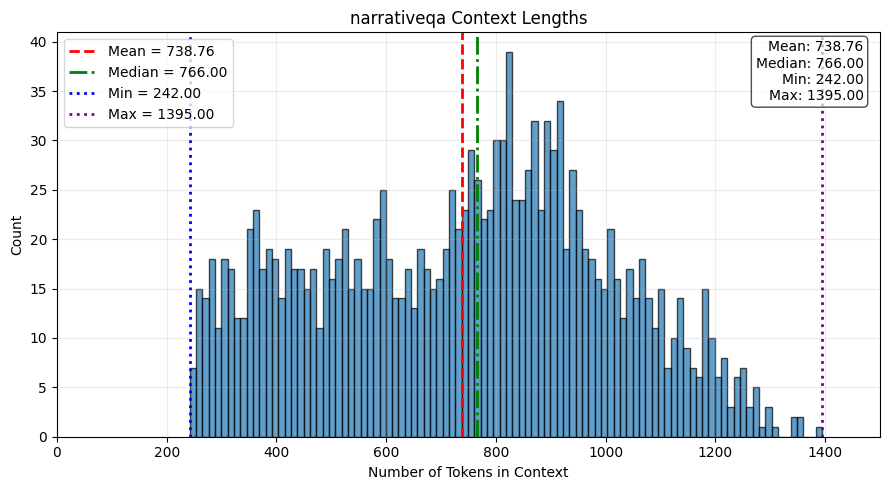

Total samples: 1572


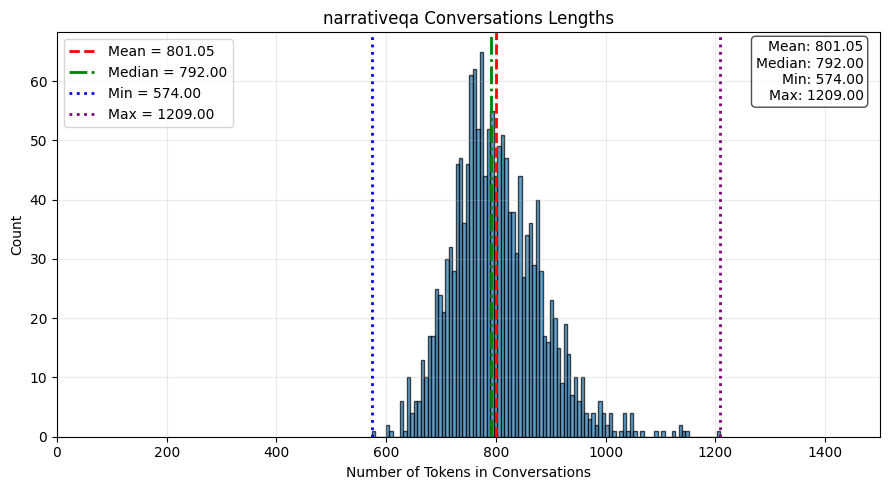

Total samples: 1572


In [27]:
plot_len_hist(
    context_lens_dict['narrativeqa'],
    bins=100,
    xlim=(0, 1500),
    title="narrativeqa Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['narrativeqa'],
    bins=100,
    xlim=(0, 1500),
    title="narrativeqa Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# QUAIL

In [28]:
# quail ('textmachinelab/quail')
output_list = []
data = datasets.load_dataset('textmachinelab/quail')
data = concatenate_datasets([
    data["train"],
    data["validation"],
    data["challenge"],
])
data = list(data)
context_to_item = {}
for item in data:
    context = item['context']
    if context not in context_to_item:
        context_to_item[context] = []
    context_to_item[context].append(item)
for i, context in enumerate(context_to_item):
    if len(context.split()) > 2048:
        print(f"skip context len: {len(context.split())}")
        continue
    qa_pairs = []
    for item in context_to_item[context]:
        question = item['question']
        answer = item['answers'][item['correct_answer_id']]
        if answer == "not enough information":
            continue
        qa_pairs.append({'question': question, 'answer': answer})
    if len(qa_pairs) == 0:
        continue
    if sum([len(qa["question"].split()) for qa in qa_pairs]) + sum([len(qa["answer"].split()) for qa in qa_pairs]) > 512:
        print(f"q eln: {[len(qa['question'].split()) for qa in qa_pairs]}, a len: {[len(qa['answer'].split()) for qa in qa_pairs]}")
        continue
    output_list.append({
        "id": f"quail.{i:04d}",
        'context': context,
        'qa_pairs': qa_pairs
    })
    
item_list = conversations_from_qapairs(output_list)
context_lens_dict['quail'], conv_lens_dict['quail'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['quail'] = item_list

# print(f"quail: {len(output_list)}, context len: {sum([len(x['context'].split()) for x in output_list]) / len(output_list)}")
# print(collections.Counter([len(item["qa_pairs"]) for item in output_list]))
# save(output_list, 'v4/quail.jsonl')
# # output_list

Computing token lengths (num_proc=16): 100%|██████████| 709/709 [00:26<00:00, 26.74 examples/s] 


In [29]:
display_conversations(item_list_dict['quail'])
pwc_datasets.append('quail')

That fall came and I went back to Michigan and the school year went by and summer came and I never really thought about it. I'm not even sure if I was officially asked, I just wound up heading back to New Jersey when school was out. I think my parents thought it was a good enough deal. They were already having some problems and without Nonna there anymore to take care of me I think my cousin's house on the coast seemed like as good a spot as any to stick me for the summer. It certainly wasn't because of any great love between me and my cousin. We weren't really very good friends at that point. I think she saw me as sort of foisted off on her and getting in the way of her summers. Which was a fair enough judgment. But she could have been nicer. It's pretty amazing that she wound up as my Maid of Honor. Time does strange things. Your lovable jack-ass of a father would mention something about magic in here. You know if you took a group of fifty strangers, had them chat with your father fo

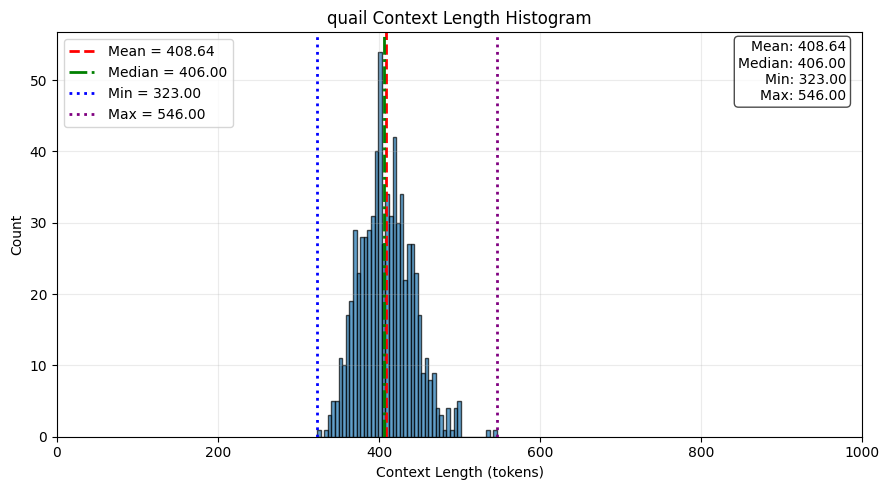

Total samples: 709


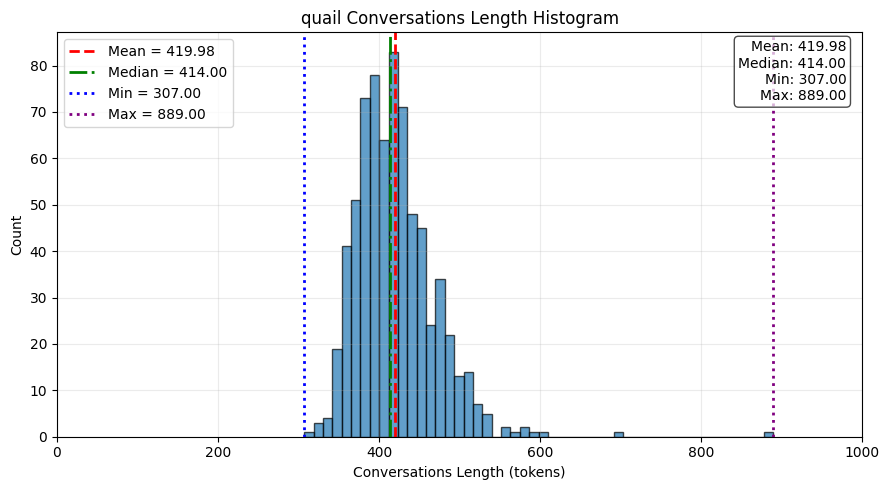

Total samples: 709


In [30]:
plot_len_hist(
    context_lens_dict['quail'],
    bins=50,
    xlim=(0, 1000),
    title="quail Context Length Histogram",
    xlabel="Context Length (tokens)",
)
plot_len_hist(
    conv_lens_dict['quail'],
    bins=50,
    xlim=(0, 1000),
    title="quail Conversations Length Histogram",
    xlabel="Conversations Length (tokens)",
)

# PwC

In [31]:
# PwC
output_list = []
data = datasets.load_dataset('sggetao/PwC')
data = list(data['train'])
context_to_item = {}
for item in data:
    context = item['input']
    if context not in context_to_item:
        context_to_item[context] = []
    context_to_item[context].append(item)
for i, context in enumerate(context_to_item):
    if len(context.split()) > 2048:
        print(f"skip context len: {len(context.split())}")
        continue
    qa_pairs = []
    for item in context_to_item[context]:
        if len(item['answer'].split()) > 128 or len(item['prompt'].split()) > 128:
            continue
        question = item['prompt']
        answer = item['answer']
        qa_pairs.append({'question': question, 'answer': answer})
    # randomly sample 5 qa pairs for each context
    # qa_pairs = qa_pairs[:8]
    while sum([len(qa["question"].split()) for qa in qa_pairs]) + sum([len(qa["answer"].split()) for qa in qa_pairs]) > 512:
        qa_pairs = qa_pairs[:-1]
        # print(f"q eln: {[len(qa['question'].split()) for qa in qa_pairs]}, a len: {[len(qa['answer'].split()) for qa in qa_pairs]}")
        continue
    output_list.append({
        "id": f"pwc.{i:04d}",
        'context': context,
        'qa_pairs': qa_pairs
    })

item_list = conversations_from_qapairs(output_list)
context_lens_dict['pwc'], conv_lens_dict['pwc'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['pwc'] = item_list

# print(f"pwc: {len(output_list)}, context len: {sum([len(x['context'].split()) for x in output_list]) / len(output_list)}")
# print(collections.Counter([len(item["qa_pairs"]) for item in output_list]))
# save(output_list, 'v4/pwc.jsonl')
# output_list

Computing token lengths (num_proc=16): 100%|██████████| 16382/16382 [01:33<00:00, 174.89 examples/s]


In [32]:
display_conversations(item_list_dict['pwc'])
pwc_datasets.append('pwc')

Actress Halle Berry has been sharing a number of stunning photos from the time she has spent in Morocco and she just posted a new one to her Instagram page that fans will not want to miss. The Sahara Desert is a stunning backdrop for any photo shoot, but when Berry is involved, there is no question that the beauty of the area is elevated significantly.

In Halle Berry's newest Instagram post, she shared a photo showing her from the back as she looks out at the Sahara Desert. It's a rather sultry shot, as Halle's back is entirely bare. Berry is sitting on the sand barefoot, and she has one arm holding up the black fabric she has around her.

Berry's other arm is sitting on her knees and she is leaning her head against her hand. Halle's long, dark tresses are free and wavy, cascading down her back, and her face isn't visible at all from this angle. Other than the black fabric draping Halle's fit physique, the only other thing she appears to be wearing is a turquoise ring or something sim

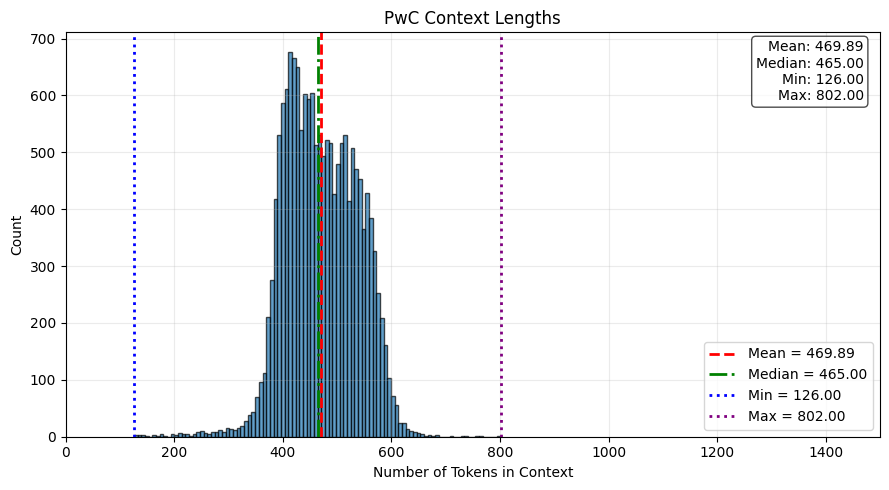

Total samples: 16382


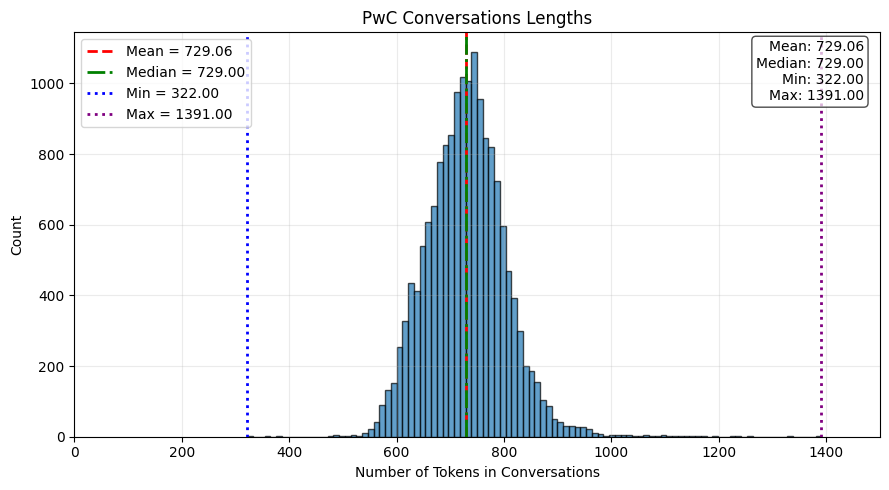

Total samples: 16382


In [33]:
plot_len_hist(
    context_lens_dict['pwc'],
    bins=100,
    xlim=(0, 1500),
    title="PwC Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['pwc'],
    bins=100,
    xlim=(0, 1500),
    title="PwC Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# Squad

In [34]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset(os.path.join("..", "data", "squad"), split="train")
text_to_idx = defaultdict(list)
for i, ex in enumerate(data):
    ctx = str(ex["context"]).strip()
    text_to_idx[ctx].append(i)
item_list = []    
for text, idxs in text_to_idx.items():
    item = {"context": text}
    qa_pairs = []
    for idx in idxs:
        ex = data[idx]
        question = str(ex["question"]).strip()
        answer = str(ex["answers"]["text"][0]).strip()
        qa_pairs.append({"question": question, "answer": answer})
    random.shuffle(qa_pairs)
    item["qa_pairs"] = qa_pairs
    item_list.append(item)
item_list = conversations_from_qapairs(item_list)
context_lens_dict['squad'], conv_lens_dict['squad'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['squad'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 18891/18891 [00:52<00:00, 363.25 examples/s] 


In [35]:
display_conversations(item_list_dict['squad'])
pwc_datasets.append('squad')

Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
user: The Basilica of the Sacred heart at Notre Dame is beside to which structure?
assistant: the Main Building
user: What is in front of the Notre Dame Main Building?
assistant: a copper statue of Christ
user: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
assistant: Saint Bern

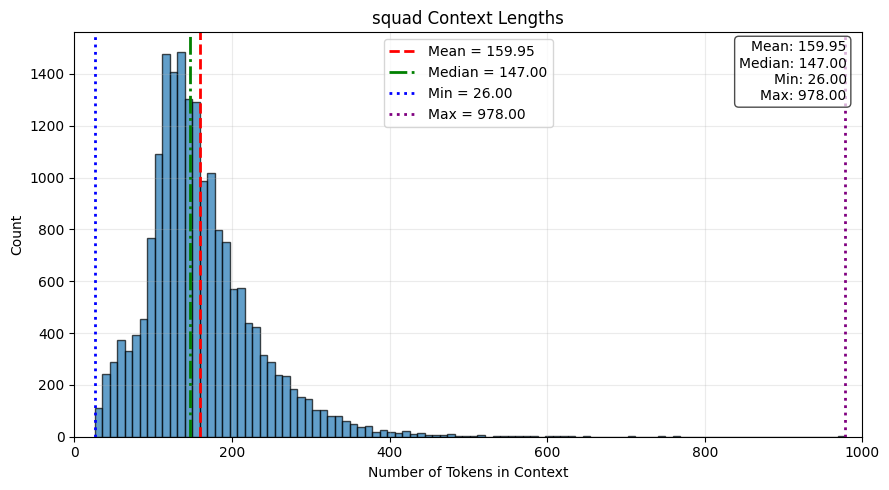

Total samples: 18891


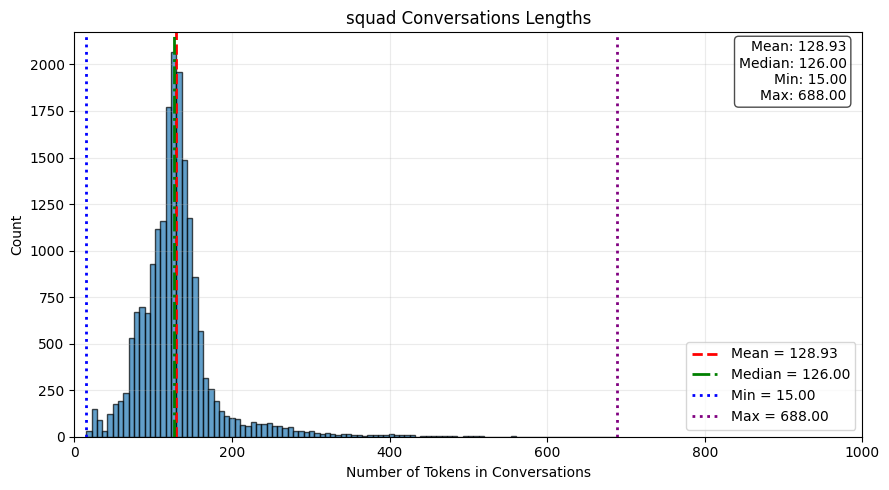

Total samples: 18891


In [36]:
plot_len_hist(
    context_lens_dict['squad'],
    bins=100,
    xlim=(0, 1000),
    title="squad Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['squad'],
    bins=100,
    xlim=(0, 1000),
    title="squad Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# race

In [37]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset("ehovy/race", "all")
data = concatenate_datasets([
    data["train"],
    data["validation"],
    data["test"],
])
data = list(data)
text_to_idx = defaultdict(list)
for i, ex in enumerate(data):
    ctx = str(ex["article"]).strip()
    text_to_idx[ctx].append(i)
item_list = []    
answer_dict = {'A':0, 'B':1, 'C':2, 'D':3}
for text, idxs in text_to_idx.items():
    item = {"context": text}
    qa_pairs = []
    for idx in idxs:
        ex = data[idx]
        question = str(ex["question"]).strip()
        answer = str(ex["options"][answer_dict[ex["answer"]]]).strip()
        qa_pairs.append({"question": question, "answer": answer})
    random.shuffle(qa_pairs)
    item["qa_pairs"] = qa_pairs
    item_list.append(item)
item_list = conversations_from_qapairs(item_list)
context_lens_dict['race'], conv_lens_dict['race'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['race'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 27931/27931 [01:13<00:00, 377.63 examples/s]


In [38]:
display_conversations(item_list_dict['race'])
pwc_datasets.append('race')

Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.
Given that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.
"Surgery ," one replied.
I was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .
One girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"
At that point, I was shocked. I am short, I can't deny that, but I don't think I would put myself th

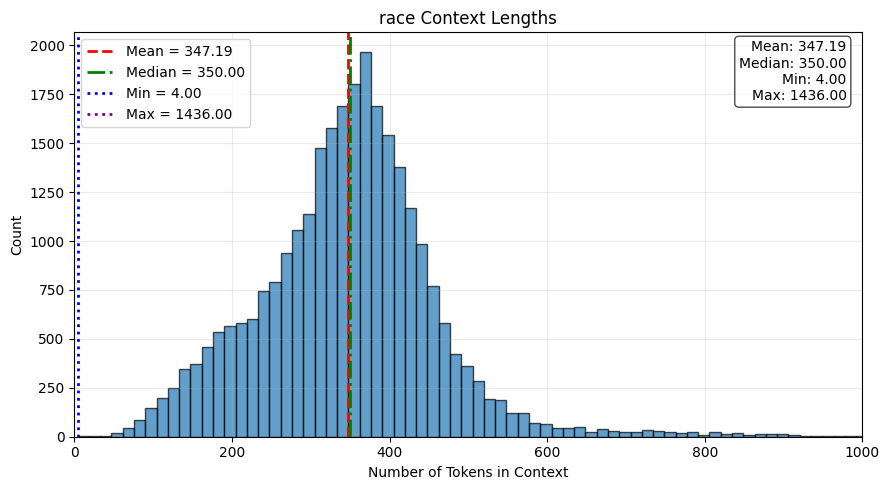

Total samples: 27931


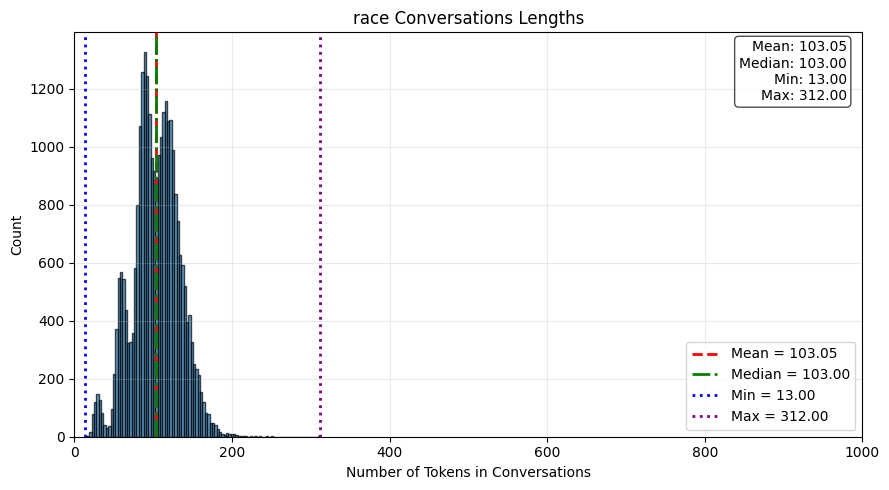

Total samples: 27931


In [39]:
plot_len_hist(
    context_lens_dict['race'],
    bins=100,
    xlim=(0, 1000),
    title="race Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['race'],
    bins=100,
    xlim=(0, 1000),
    title="race Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# newsqa

In [40]:
from datasets import load_dataset

data = load_dataset("gabrieltorresgamez/newsqa")
data = concatenate_datasets([
    data["train"],
    data["validation"],
    data["test"],
])
data = list(data)
item_list = []
for item in data:
    context = item['paragraph']
    questions = item['questions']
    answers = item['answers']
    qa_pairs = []
    for question, answer in zip(questions, answers):
        qa_pairs.append({"question": question.strip(), "answer": answer.strip()})
    item_list.append({
        "context": context,
        "qa_pairs": qa_pairs
    })
item_list = conversations_from_qapairs(item_list)
context_lens_dict['newsqa'], conv_lens_dict['newsqa'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['newsqa'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 11475/11475 [01:01<00:00, 185.13 examples/s]


In [41]:
display_conversations(item_list_dict['newsqa'])
pwc_datasets.append('newsqa')

"Everything can be improved." -- Ross Lovegrove



Designer Ross Lovegrove



Fiercely original and unapologetically innovative, Ross Lovegrove describes himself, somewhat reluctantly, as an industrial designer. "It's not as grimy, it's not as deep and dark as that sounds," he says. Famous for his tactile and sensual fluid forms, he takes his inspiration from nature to create an organic minimalism that he calls "fat free" design.



"Nature is a very big part of my work and always has been. I've never seen it as a trend or a fashion," he told CNN.



In the early 1980s, with Frog Design in West Germany, he worked on projects including Sony Walkmans and Apple computers. He later moved to Paris as a consultant to Knoll International.



Since returning to London in 1986, Lovegrove has worked with a wide range of clients including Airbus Industries, Peugeot, Apple Computers, Issey Miyake, Olympus Cameras, Tag Heuer, Herman Miller, Japan Airlines and Toyo Ito Architects in Japan, as well a

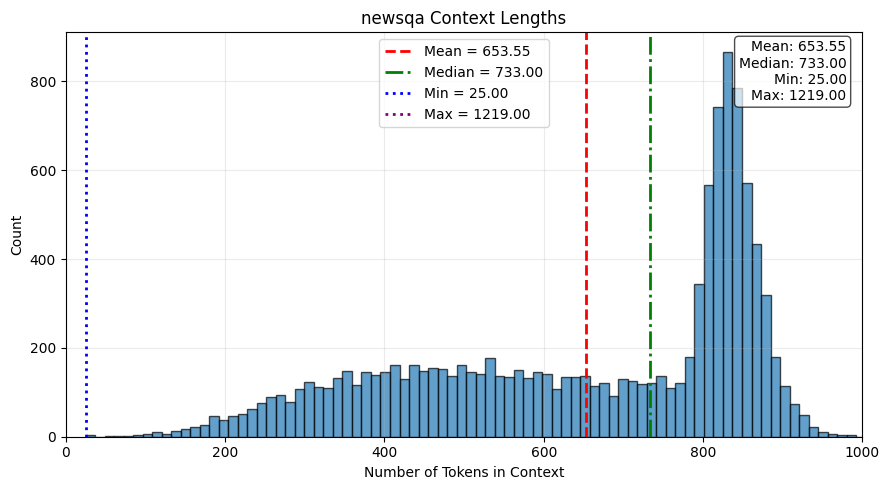

Total samples: 11475


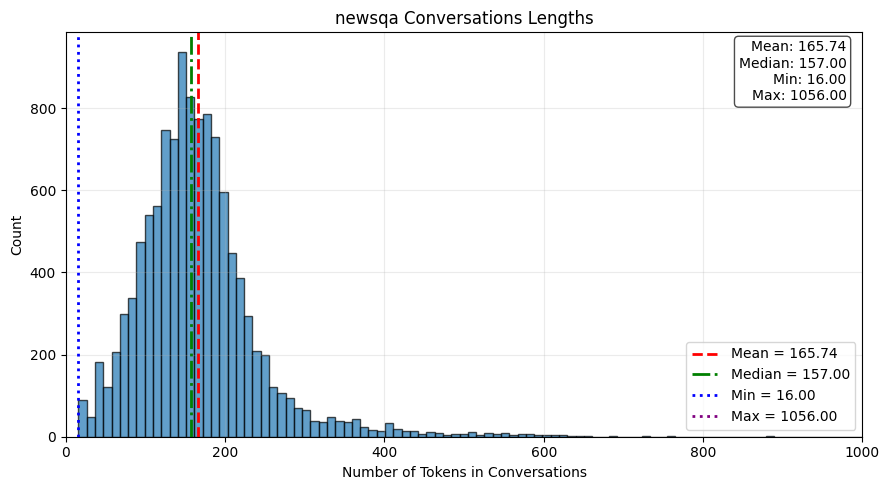

Total samples: 11475


In [42]:
plot_len_hist(
    context_lens_dict['newsqa'],
    bins=100,
    xlim=(0, 1000),
    title="newsqa Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['newsqa'],
    bins=100,
    xlim=(0, 1000),
    title="newsqa Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# duorc(selfrc, easy)

In [43]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset("ibm-research/duorc", "SelfRC")
data = concatenate_datasets([
    data["train"],
    data["validation"],
    data["test"],
])
data = list(data)

text_to_idx = defaultdict(list)
for i, ex in enumerate(data):
    ctx = str(ex["plot"]).strip()
    text_to_idx[ctx].append(i)
item_list = []    
for text, idxs in text_to_idx.items():
    item = {"context": text}
    qa_pairs = []
    for idx in idxs:
        ex = data[idx]
        question = str(ex["question"]).strip()
        if len(ex["answers"]) > 0:  
            answer = str(ex["answers"][0]).strip()
            qa_pairs.append({"question": question, "answer": answer})
    if len(qa_pairs) == 0:
        continue
    item["qa_pairs"] = qa_pairs
    item_list.append(item)
item_list = conversations_from_qapairs(item_list)
context_lens_dict['duorc/selfrc'], conv_lens_dict['duorc/selfrc'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['duorc/selfrc'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 6791/6791 [00:40<00:00, 166.20 examples/s]


In [44]:
display_conversations(item_list_dict['duorc/selfrc'])
pwc_datasets.append('duorc/selfrc')

200 years in the future, Mars has been colonized by a high-tech company.
Melanie Ballard (Natasha Henstridge) arrives by train to a Mars mining camp which has cut all communication links with the company headquarters. She's not alone, as she is with a group of fellow police officers. They find the mining camp deserted except for a person in the prison, Desolation Williams (Ice Cube), who seems to laugh about them because they are all going to die. They were supposed to take Desolation to headquarters, but decide to explore first to find out what happened.They find a man inside an encapsulated mining car, who tells them not to open it. However, they do and he tries to kill them. One of the cops witnesses strange men with deep scarred and heavily tattooed faces killing the remaining survivors. The cops realise they need to leave the place fast.Desolation explains that the miners opened a kind of Martian construction in the soil which unleashed red dust. Those who breathed that dust becam

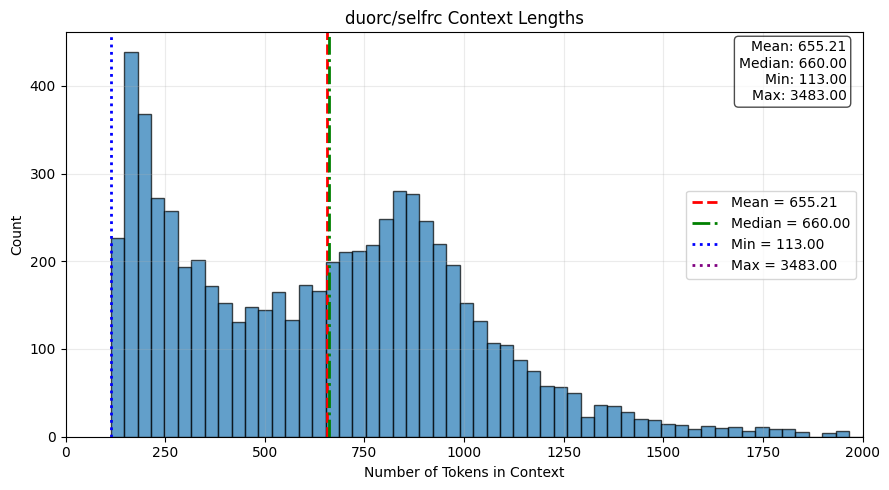

Total samples: 6791


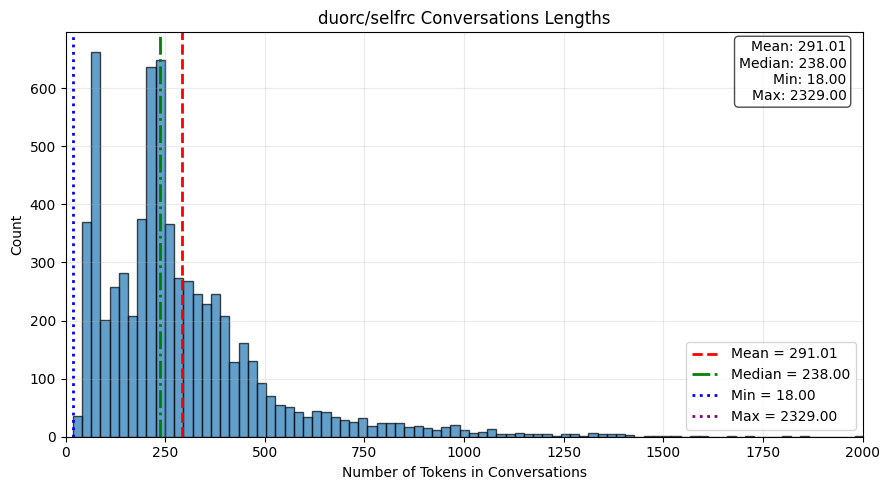

Total samples: 6791


In [45]:
plot_len_hist(
    context_lens_dict['duorc/selfrc'],
    bins=100,
    xlim=(0, 2000),
    title="duorc/selfrc Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['duorc/selfrc'],
    bins=100,
    xlim=(0, 2000),
    title="duorc/selfrc Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# duorc(paraphraserc hard)

In [46]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset("ibm-research/duorc", "ParaphraseRC")
data = concatenate_datasets([
    data["train"],
    data["validation"],
    data["test"],
])
data = list(data)

text_to_idx = defaultdict(list)
for i, ex in enumerate(data):
    ctx = str(ex["plot"]).strip()
    text_to_idx[ctx].append(i)
item_list = []    
for text, idxs in text_to_idx.items():
    item = {"context": text}
    qa_pairs = []
    for idx in idxs:
        ex = data[idx]
        question = str(ex["question"]).strip()
        if len(ex["answers"]) > 0:  
            answer = str(ex["answers"][0]).strip()
            qa_pairs.append({"question": question, "answer": answer})
    if len(qa_pairs) == 0:
        continue
    item["qa_pairs"] = qa_pairs
    item_list.append(item)
item_list = conversations_from_qapairs(item_list)
context_lens_dict['duorc/paraphraserc'], conv_lens_dict['duorc/paraphraserc'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['duorc/paraphraserc'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 7271/7271 [01:00<00:00, 120.17 examples/s]


In [47]:
display_conversations(item_list_dict['duorc/paraphraserc'])
pwc_datasets.append('duorc/paraphraserc')   

Set in the second half of the 22nd century, Mars has been 84% terraformed, allowing humans to walk on the surface without pressure suits. Martian society has become matriarchal, with women in most positions of authority. The story concerns police officer Melanie Ballard (Natasha Henstridge), second in command of a team alongside Sergeant Jericho (Jason Statham) sent to a remote mining outpost to transport prisoner Desolation Williams (Ice Cube). Arriving at the remote mining town, Ballard finds all of the people missing. She learns that they had discovered an underground doorway created by an ancient Martian civilization. When the door was opened it released disembodied spirits or "ghosts", which took possession of the miners.
The possessed miners commit horrific acts of death and destruction, along with self-mutilation. When team leader Helena Bradock (Pam Grier) is murdered, Ballard must assume command, fight off the possessed miners, escape the town and hopefully destroy the ghosts.

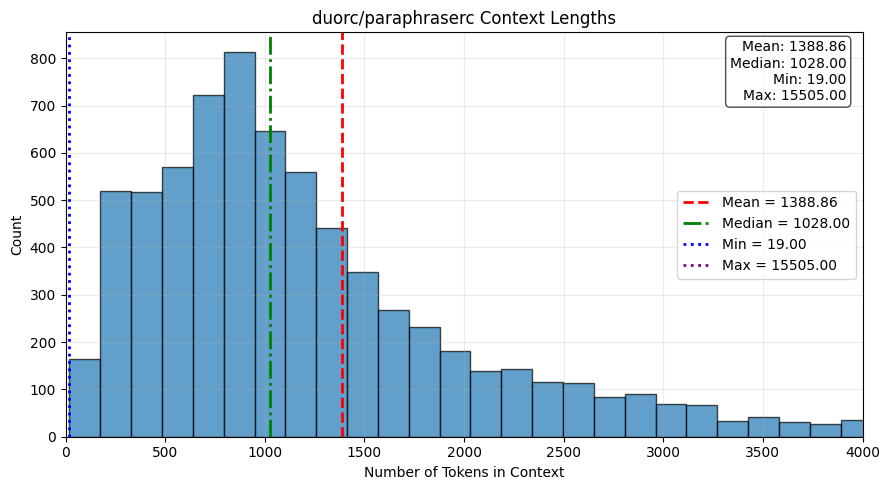

Total samples: 7271


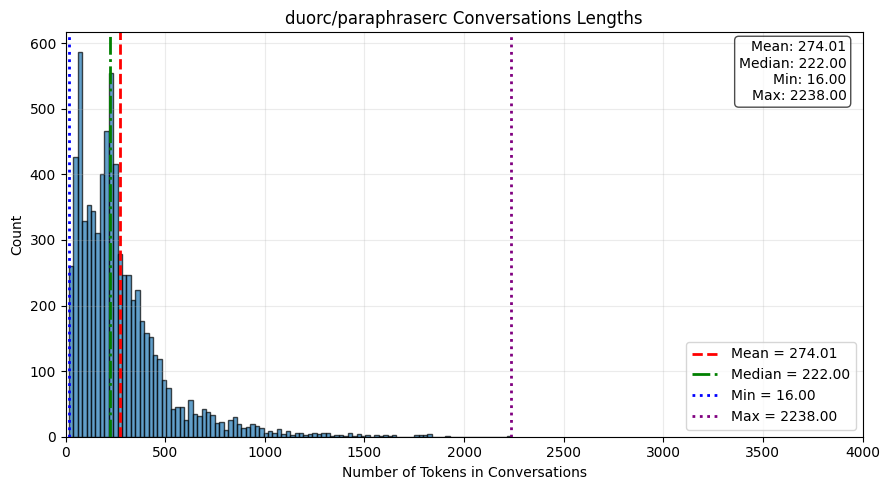

Total samples: 7271


In [48]:
plot_len_hist(
    context_lens_dict['duorc/paraphraserc'],
    bins=100,
    xlim=(0, 4000),
    title="duorc/paraphraserc Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['duorc/paraphraserc'],
    bins=100,
    xlim=(0, 4000),
    title="duorc/paraphraserc Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# Final

In [49]:
print("All datasets:", list(item_list_dict.keys()))
print("PwC datasets:", pwc_datasets)

All datasets: ['msmacro-mqa', 'msmacrov2-mqa', 'quac', 'coqa', 'drop', 'narrativeqa', 'quail', 'pwc', 'squad', 'race', 'newsqa', 'duorc/selfrc', 'duorc/paraphraserc']
PwC datasets: ['msmacro-mqa', 'msmacrov2-mqa', 'quac', 'coqa', 'drop', 'narrativeqa', 'quail', 'pwc', 'squad', 'race', 'newsqa', 'duorc/selfrc', 'duorc/paraphraserc']


In [50]:
# postprocess First letter of answer always uppercase
for dataset_name, item_list in item_list_dict.items():
    for item in item_list:
        for conv in item['conversations']:
            if conv['role'] == 'assistant' and len(conv['content']) > 0:
                conv['content'] = conv['content'][0].upper() + conv['content'][1:]

# randomly show five conversations from each dataset
for dataset_name, item_list in item_list_dict.items():
    print("===============================================")
    print("-----------------------------------------------")
    print("===============================================")
    print(f"Dataset: {dataset_name}")
    display_conversations(item_list, firstk=5)

-----------------------------------------------
Dataset: msmacro-mqa
Herne Bay /hɜrn/ is a seaside town in Kent, South East England, with a population of 38,563. On the south coast of the Thames Estuary it is 7 miles (11 km) north of Canterbury and 5 miles (8 km) east of Whitstable. Herne Bay railway station is on the Chatham Main Line, which runs between Ramsgate in East Kent and London Victoria. Other stations on this line include Broadstairs, Margate, Whitstable, Faversham, Gillingham, Rochester and Bromley South. Herne Bay is around 1 hour and 40 minutes from London

Whitstable and Eastbourne have headed a list of the UK's fastest growing seaside resort destinations, with massive investment and an expansion of high-end tourism cited as major factors in a reversal of fortunes for the UK's seaside destinations. The trend, helped by £100 million worth of public investment in seaside towns, resulted in 21 per cent more UK holidaymakers staying overnight and spending almost a quarter mo

In [51]:
import pandas as pd
import numpy as np

def table(dataset_names):
    rows = []
    for dataset_name in dataset_names:
        context_lens = context_lens_dict[dataset_name]
        conv_lens = conv_lens_dict[dataset_name]
        rows.append({
            "Dataset": dataset_name,
            "Sample Numbers": len(context_lens),
            "Context Mean": np.mean(context_lens),
            "Context Median": np.median(context_lens),
            "Context Min": np.min(context_lens),
            "Context Max": np.max(context_lens),
            "Conversations Mean": np.mean(conv_lens),
            "Conversations Median": np.median(conv_lens),
            "Conversations Min": np.min(conv_lens),
            "Conversations Max": np.max(conv_lens),
        })
    df = pd.DataFrame(rows)
    df.style.hide(axis="index")
    df.style.format(precision=2).background_gradient(cmap="Blues").hide(axis="index")
    print("====================================================")
    print(df.to_string(index=False))
    print("====================================================")

def statistics(dataset_names):
    print("----------------------------------------------------")
    total_numbers = 0
    total_context_len = 0
    total_conversation_len = 0
    for dataset_name in dataset_names:
        item_list = item_list_dict[dataset_name]
        total_numbers += len(item_list)
        total_context_len += sum(context_lens_dict[dataset_name])
        total_conversation_len += sum(conv_lens_dict[dataset_name])
    avg_contexts_len = total_context_len / total_numbers
    avg_conversations_len = total_conversation_len / total_numbers
    print(dataset_names)
    print(f"Total samples: {total_numbers}")
    print(f"Average context length: {avg_contexts_len:.2f}")
    print(f"Average conversations length: {avg_conversations_len:.2f}")


print(f"All datasets:")
statistics(list(item_list_dict.keys()))
table(list(item_list_dict.keys()))

print(f"pwc-datasets:")
statistics(pwc_datasets)
table(pwc_datasets)


All datasets:
----------------------------------------------------
['msmacro-mqa', 'msmacrov2-mqa', 'quac', 'coqa', 'drop', 'narrativeqa', 'quail', 'pwc', 'squad', 'race', 'newsqa', 'duorc/selfrc', 'duorc/paraphraserc']
Total samples: 492398
Average context length: 714.58
Average conversations length: 519.47


           Dataset  Sample Numbers  Context Mean  Context Median  Context Min  Context Max  Conversations Mean  Conversations Median  Conversations Min  Conversations Max
       msmacro-mqa           92241    798.784250           857.0           99         1701          595.978773                 581.0                344               1184
     msmacrov2-mqa          283761    781.268839           691.0           44         2581          594.659291                 579.0                338               1548
              quac           11567    686.246131           650.0          395         2667          234.666638                 225.0                 19                629
              coqa            7699    356.696844           356.0           89         1323          309.349916                 330.0                 15                794
              drop            6108    308.703831           272.0           46         2302          374.700720                 311.0             

In [52]:
# concatenate all into one
import os
import json
import glob
from typing import List
import numpy as np

def generate_dataset(item_list_dict, dataset_names, output_path):
    output_list = []
    context_len_list = []
    conversation_len_list = []
    for dataset_name in dataset_names:
        print(f"Processing dataset: {dataset_name}")
        assert dataset_name in item_list_dict, f"{dataset_name} not in item_list_dict"
        output_list.extend(item_list_dict[dataset_name])
        context_len_list.extend(context_lens_dict[dataset_name])
        conversation_len_list.extend(conv_lens_dict[dataset_name])
    for i in range(len(output_list)):
        output_list[i] = {"contextlen": int(context_len_list[i]), "conversationlen": int(conversation_len_list[i]), "context": output_list[i]["context"], "conversations": output_list[i]["conversations"]}
    with open(output_path, "w") as f:
        json.dump(output_list, f, indent=2)
    print(f"{output_path}: {len(output_list)}")

In [53]:
generate_dataset(item_list_dict, pwc_datasets, os.path.join("..", "data", "ift_pwc.json"))

Processing dataset: msmacro-mqa
Processing dataset: msmacrov2-mqa
Processing dataset: quac
Processing dataset: coqa
Processing dataset: drop
Processing dataset: narrativeqa
Processing dataset: quail
Processing dataset: pwc
Processing dataset: squad
Processing dataset: race
Processing dataset: newsqa
Processing dataset: duorc/selfrc
Processing dataset: duorc/paraphraserc
../data/ift_pwc.json: 492398
